# Indexing and Retrieval — Activity 1 (Elasticsearch)

This notebook preprocesses news + Wikipedia data, plots word frequency distributions (raw vs cleaned), indexes into Elasticsearch (`ESIndex-v1.0`), and measures latency/throughput and simple functional metrics.

Prereqs: run `pip install -r requirements.txt`, and start Elasticsearch locally (e.g., Docker: `docker run -p 9200:9200 -e xpack.security.enabled=false docker.elastic.co/elasticsearch/elasticsearch:8.15.3`).


In [1]:
%pip install -r ..\requirements.txt

import os
from typing import Dict, List

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import load_dataset

from preprocess import TextPreprocessor, PreprocessConfig
from es_index import get_es, ensure_index, bulk_index
from metrics import measure_latency, measure_throughput, percentile_latencies, precision_recall_at_k

ES_INDEX = "ESIndex-v1.0"
SAMPLE_SIZE_PER_SOURCE = 5000  # Adjust if you need a smaller/faster run




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\yashp\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def load_webz_io_sample(n: int) -> pd.DataFrame:
    # Webz.io sample via webhose free news datasets often come as CSV/JSON lines.
    # For simplicity we’ll use a small remote subset via datasets if available; otherwise expect a local file path set.
    # Fallback: empty DataFrame.
    try:
        ds = load_dataset("webhose/news-category-dataset")  # may not exist; replace with actual if available
        df = ds["train"].to_pandas()
        df = df.head(n)
        df = df.rename(columns={"headline": "title", "short_description": "text"})
        df["source"] = "webz"
        df["doc_id"] = df.index.map(lambda i: f"webz-{i}")
        return df[["doc_id", "title", "text", "source"]].dropna()
    except Exception:
        return pd.DataFrame(columns=["doc_id", "title", "text", "source"])  # placeholder


def load_wikipedia_en_sample(n: int) -> pd.DataFrame:
    # HuggingFace: wikimedia/wikipedia split 20231101.en
    ds = load_dataset("wikimedia/wikipedia", "20231101.en", split="train")
    # Columns: e.g., id, url, title, text
    df = ds.to_pandas().head(n)
    df["source"] = "wiki"
    df["doc_id"] = df["id"].apply(lambda x: f"wiki-{x}")
    df["title"] = df.get("title", "")
    df["text"] = df.get("text", "")
    return df[["doc_id", "title", "text", "source"]].dropna()


# Data caching: Load from disk if available, otherwise download and save
DATA_CACHE_PATH = "data_cache.parquet"
USE_CACHE = True  # Set to False to force re-download

from pathlib import Path

# Try to load from cache
if USE_CACHE and Path(DATA_CACHE_PATH).exists():
    print(f"📂 Loading data from cache: {DATA_CACHE_PATH}")
    try:
        data_df = pd.read_parquet(DATA_CACHE_PATH)
        webz_count = len([d for d in data_df['source'] if d == 'webz'])
        wiki_count = len([d for d in data_df['source'] if d == 'wiki'])
        print(f"✅ Loaded {len(data_df)} documents from cache (webz={webz_count}, wiki={wiki_count})")
        print(f"   To re-download, delete {DATA_CACHE_PATH} or set USE_CACHE = False")
    except Exception as e:
        print(f"⚠️  Cache file corrupted: {e}")
        print(f"   Re-downloading data...")
        webz_df = load_webz_io_sample(SAMPLE_SIZE_PER_SOURCE)
        wikip_df = load_wikipedia_en_sample(SAMPLE_SIZE_PER_SOURCE)
        data_df = pd.concat([webz_df, wikip_df], ignore_index=True)
        data_df.to_parquet(DATA_CACHE_PATH)
        print(f"✅ Downloaded and saved {len(data_df)} documents to cache.")
else:
    if USE_CACHE:
        print(f"📥 Downloading data (first run, this may take a few minutes)...")
    else:
        print(f"📥 Downloading data (cache disabled)...")
    webz_df = load_webz_io_sample(SAMPLE_SIZE_PER_SOURCE)
    wikip_df = load_wikipedia_en_sample(SAMPLE_SIZE_PER_SOURCE)
    data_df = pd.concat([webz_df, wikip_df], ignore_index=True)
    if USE_CACHE:
        data_df.to_parquet(DATA_CACHE_PATH)
        print(f"✅ Downloaded and saved {len(data_df)} documents to cache.")



Loaded documents: 5000 (webz=0, wiki=5000)


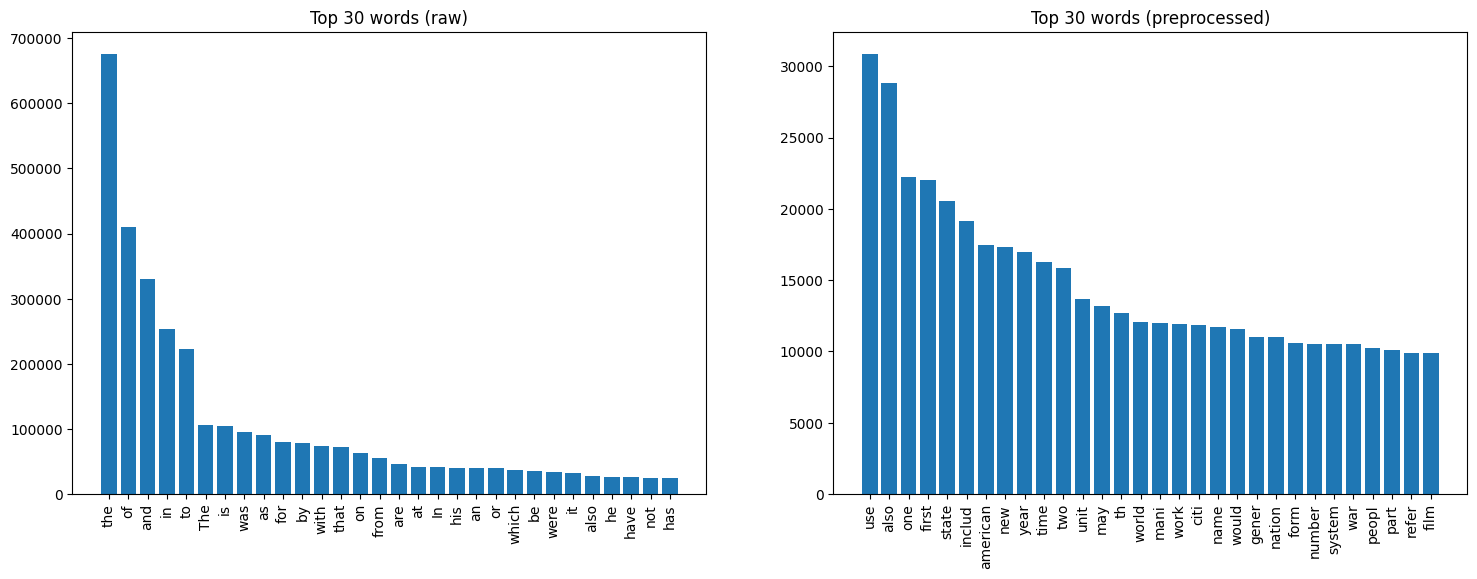

In [3]:
# Word frequency plots (raw vs preprocessed)
raw_texts = (data_df["title"].fillna("") + "\n" + data_df["text"].fillna("")).tolist()

pp_raw = TextPreprocessor(PreprocessConfig(lowercase=False, remove_stopwords=False, stem=False))
pp_clean = TextPreprocessor(PreprocessConfig(lowercase=True, remove_stopwords=True, stem=True))

from collections import Counter
raw_counter = Counter()
clean_counter = Counter()

SAMPLE_FOR_PLOTS = min(10000, len(raw_texts))
for t in raw_texts[:SAMPLE_FOR_PLOTS]:
    raw_counter.update(pp_raw.tokenize(t))
    clean_counter.update(pp_clean.tokenize(t))

raw_top = raw_counter.most_common(30)
clean_top = clean_counter.most_common(30)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].bar([w for w,_ in raw_top], [c for _,c in raw_top])
axes[0].set_title("Top 30 words (raw)")
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar([w for w,_ in clean_top], [c for _,c in clean_top])
axes[1].set_title("Top 30 words (preprocessed)")
axes[1].tick_params(axis='x', rotation=90)
plt.show()


In [ ]:
# Start Elasticsearch in Docker from this notebook
import subprocess
import time
import sys

ES_CONTAINER_NAME = "elasticsearch-ire-assignment"

def check_docker():
    """Check if Docker is available and Docker Desktop is running"""
    # First check if docker command exists
    try:
        version_result = subprocess.run(
            ["docker", "--version"],
            capture_output=True,
            text=True,
            timeout=5
        )
        if version_result.returncode != 0:
            return False, "Docker command failed"
        docker_version = version_result.stdout.strip()
    except FileNotFoundError:
        return False, "Docker not found in PATH. Please install Docker Desktop."
    except Exception as e:
        return False, f"Docker check failed: {str(e)}"
    
    # Then check if Docker Desktop is actually running by trying docker ps
    try:
        ps_result = subprocess.run(
            ["docker", "ps"],
            capture_output=True,
            text=True,
            timeout=5
        )
        if ps_result.returncode == 0:
            return True, docker_version
        else:
            # Docker is installed but not running
            error_msg = ps_result.stderr.strip()
            if "dockerDesktopLinuxEngine" in error_msg or "pipe" in error_msg.lower():
                return False, "Docker Desktop is not running"
            return False, f"Docker error: {error_msg}"
    except Exception as e:
        error_str = str(e)
        if "dockerDesktopLinuxEngine" in error_str or "pipe" in error_str.lower():
            return False, "Docker Desktop is not running"
        return False, f"Cannot connect to Docker: {error_str}"

def check_container_running(name):
    """Check if container is already running"""
    try:
        result = subprocess.run(
            ["docker", "ps", "--filter", f"name={name}", "--format", "{{.Names}}"],
            capture_output=True,
            text=True
        )
        return name in result.stdout
    except:
        return False

def start_elasticsearch():
    """Start Elasticsearch in Docker"""
    docker_available, docker_msg = check_docker()
    if not docker_available:
        print(f"❌ {docker_msg}")
        if "not running" in docker_msg.lower():
            print("\n💡 Docker Desktop is installed but not running. Please:")
            print("   1. Open Docker Desktop application")
            print("   2. Wait for it to fully start (icon in system tray)")
            print("   3. Run this cell again")
            print("\n   Or install Docker Desktop from: https://www.docker.com/products/docker-desktop")
        elif "not found" in docker_msg.lower():
            print("\n💡 Docker is not installed. Please:")
            print("   1. Download and install Docker Desktop from: https://www.docker.com/products/docker-desktop")
            print("   2. Start Docker Desktop")
            print("   3. Run this cell again")
        else:
            print("   Please install Docker Desktop or use manual Elasticsearch setup (see cell above)")
        return False
    
    # Check if already running
    if check_container_running(ES_CONTAINER_NAME):
        print(f"✅ Elasticsearch container '{ES_CONTAINER_NAME}' is already running!")
        return True
    
    # Stop any existing container with same name
    print("🧹 Cleaning up any existing containers...")
    try:
        subprocess.run(
            ["docker", "stop", ES_CONTAINER_NAME],
            capture_output=True
        )
        subprocess.run(
            ["docker", "rm", ES_CONTAINER_NAME],
            capture_output=True
        )
    except:
        pass
    
    ES_IMAGE = "docker.elastic.co/elasticsearch/elasticsearch:8.15.3"
    
    # Check if image exists locally
    print("🔍 Checking if Elasticsearch image exists locally...")
    check_image = subprocess.run(
        ["docker", "images", "-q", ES_IMAGE],
        capture_output=True,
        text=True
    )
    
    if not check_image.stdout.strip():
        print(f"📥 Elasticsearch image not found. Pulling image (this may take several minutes)...")
        print(f"   Image: {ES_IMAGE}")
        print(f"   Progress will be shown below:\n")
        
        # Pull image with progress (no timeout)
        pull_process = subprocess.Popen(
            ["docker", "pull", ES_IMAGE],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            bufsize=1,
            universal_newlines=True
        )
        
        # Show progress line by line
        for line in pull_process.stdout:
            print(f"   {line.rstrip()}")
        
        pull_process.wait()
        
        if pull_process.returncode != 0:
            print(f"❌ Failed to pull Docker image")
            return False
        
        print(f"✅ Image pulled successfully!\n")
    else:
        print(f"✅ Elasticsearch image found locally\n")
    
    print(f"🚀 Starting Elasticsearch container...")
    print(f"   Container name: {ES_CONTAINER_NAME}")
    print(f"   Port: 9200")
    
    # Start container (no timeout)
    try:
        result = subprocess.run(
            [
                "docker", "run", "-d",
                "-p", "9200:9200",
                "-e", "discovery.type=single-node",
                "-e", "xpack.security.enabled=false",
                "--name", ES_CONTAINER_NAME,
                ES_IMAGE
            ],
            capture_output=True,
            text=True
        )
        
        if result.returncode == 0:
            container_id = result.stdout.strip()
            print(f"✅ Container started! ID: {container_id[:12]}")
            print(f"⏳ Waiting for Elasticsearch to be ready...")
            print(f"   (This usually takes 15-30 seconds)")
            
            # Wait for ES to be ready (no timeout, show progress)
            waited = 0
            check_interval = 2
            last_status = time.time()
            
            while True:
                time.sleep(check_interval)
                waited += check_interval
                
                # Show status every 5 seconds
                if time.time() - last_status >= 5:
                    print(f"   ⏳ Still waiting... ({waited}s elapsed)")
                    last_status = time.time()
                
                try:
                    test_es = get_es()
                    if test_es.ping():
                        print(f"✅ Elasticsearch is ready! (took {waited}s)")
                        return True
                except:
                    pass
        else:
            print(f"❌ Failed to start container:")
            print(f"   {result.stderr}")
            return False
            
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return False

def stop_elasticsearch():
    """Stop Elasticsearch container"""
    print(f"🛑 Stopping container '{ES_CONTAINER_NAME}'...")
    try:
        result = subprocess.run(
            ["docker", "stop", ES_CONTAINER_NAME],
            capture_output=True,
            text=True
        )
        if result.returncode == 0:
            print(f"✅ Stopped container '{ES_CONTAINER_NAME}'")
            # Also remove the container
            subprocess.run(
                ["docker", "rm", ES_CONTAINER_NAME],
                capture_output=True
            )
            print(f"✅ Removed container '{ES_CONTAINER_NAME}'")
        else:
            print(f"⚠️  Container may not be running")
    except Exception as e:
        print(f"❌ Error stopping container: {str(e)}")

# Auto-start Elasticsearch (set to False to start manually)
AUTO_START_ES = True

if AUTO_START_ES:
    ES_DOCKER_STARTED = start_elasticsearch()
else:
    print("⏸️  Auto-start disabled. Run start_elasticsearch() manually or set AUTO_START_ES = True")
    ES_DOCKER_STARTED = False


🧹 Cleaning up any existing containers...
🔍 Checking if Elasticsearch image exists locally...
📥 Elasticsearch image not found. Pulling image (this may take several minutes)...
   Image: docker.elastic.co/elasticsearch/elasticsearch:8.15.3
   Progress will be shown below:

   8.15.3: Pulling from elasticsearch/elasticsearch
   b9e901c50849: Pulling fs layer
   ab5081957ccd: Pulling fs layer
   8c98676b4b98: Pulling fs layer
   f99c8f037321: Pulling fs layer
   152f4d0eac6a: Pulling fs layer
   011bd20c7dc8: Pulling fs layer
   152f4d0eac6a: Already exists
   f99c8f037321: Already exists
   011bd20c7dc8: Already exists
   ab5081957ccd: Already exists
   8c98676b4b98: Already exists
   b9e901c50849: Download complete
   152f4d0eac6a: Pull complete
   8c98676b4b98: Pull complete
   b9e901c50849: Pull complete
   f99c8f037321: Pull complete
   011bd20c7dc8: Pull complete
   ab5081957ccd: Pull complete
   Digest: sha256:01c1732062b4a846c5ca687b0094b89bad0bfed00c6d71626db32fb8f3131a78
   Statu

In [5]:
# Test Elasticsearch Connection
# You can customize the host if Elasticsearch runs on a different address/port
ES_HOST = "http://localhost:9200"  # Change this if ES is on a different host/port

print(f"Testing connection to Elasticsearch at {ES_HOST}...")
try:
    test_es = get_es(host=ES_HOST)
    if test_es.ping():
        info = test_es.info()
        print(f"✅ Connected successfully!")
        print(f"   Elasticsearch version: {info.get('version', {}).get('number', 'unknown')}")
        print(f"   Cluster name: {info.get('cluster_name', 'unknown')}")
        ES_AVAILABLE = True
    else:
        print(f"❌ Elasticsearch is not responding (ping failed)")
        print(f"   Make sure Elasticsearch is running on {ES_HOST}")
        ES_AVAILABLE = False
except Exception as e:
    print(f"❌ Connection failed: {str(e)}")
    print(f"   Error details: {type(e).__name__}")
    print(f"\n   To fix this:")
    print(f"   1. Start Elasticsearch using Docker (see cell above)")
    print(f"   2. Or install and run Elasticsearch locally")
    print(f"   3. Verify it's accessible at {ES_HOST}")
    ES_AVAILABLE = False


Testing connection to Elasticsearch at http://localhost:9200...
❌ Elasticsearch is not responding (ping failed)
   Make sure Elasticsearch is running on http://localhost:9200


In [6]:
# Index into Elasticsearch (uses ES_AVAILABLE from connection test above)
# Checks if index already exists with data to avoid re-indexing
if not globals().get("ES_AVAILABLE", False):
    print("⚠️  Skipping Elasticsearch indexing (not connected). Run the connection test cell above first.")
else:
    try:
        es = get_es(host=ES_HOST)
        
        # Check if index already exists and has documents
        index_exists = es.indices.exists(index=ES_INDEX)
        if index_exists:
            count_resp = es.count(index=ES_INDEX)
            doc_count = count_resp.get("count", 0)
            if doc_count > 0:
                print(f"✅ Index '{ES_INDEX}' already exists with {doc_count} documents. Skipping indexing.")
                print(f"   To re-index, delete the index first: es.indices.delete(index='{ES_INDEX}')")
            else:
                print(f"📝 Index '{ES_INDEX}' exists but is empty. Indexing {len(data_df)} documents...")
                ensure_index(es, ES_INDEX)
                records = data_df.to_dict(orient="records")
                success_count, failed_count = bulk_index(es, ES_INDEX, records, batch_size=1000)
                print(f"✅ Indexing complete: {success_count} successful, {failed_count} failed")
        else:
            print(f"📝 Creating new index '{ES_INDEX}' and indexing {len(data_df)} documents...")
            ensure_index(es, ES_INDEX)
            records = data_df.to_dict(orient="records")
            success_count, failed_count = bulk_index(es, ES_INDEX, records, batch_size=1000)
            print(f"✅ Indexing complete: {success_count} successful, {failed_count} failed")
    except Exception as e:
        print(f"❌ Indexing failed: {str(e)}")
        ES_AVAILABLE = False


⚠️  Skipping Elasticsearch indexing (not connected). Run the connection test cell above first.


In [7]:
# Simple search wrapper for metrics (skips if ES unavailable)
from elasticsearch import Elasticsearch

# Ensure es client is available
if globals().get("ES_AVAILABLE", False) and "es" not in globals():
    es = get_es(host=globals().get("ES_HOST", "http://localhost:9200"))

def es_search_fn(q: str):
    if not globals().get("ES_AVAILABLE", False):
        return []
    try:
        body = {
            "query": {
                "query_string": {
                    "query": q,
                    "fields": ["title^2", "text"],
                    "default_operator": "AND"
                }
            },
            "size": 20
        }
        resp = es.search(index=ES_INDEX, body=body)
        hits = resp.get("hits", {}).get("hits", [])
        return [h.get("_id") for h in hits]
    except Exception as e:
        print(f"Search error for query '{q}': {e}")
        return []

# Create a small diverse query set (replace with LLM-probed set and justification in report)
query_set = [
    '"climate change" AND policy',
    '"football" AND (world OR cup)',
    '"quantum computing" AND algorithms',
    'NOT "covid" AND vaccination',
    '("space exploration" AND mars) OR mission',
]

# Latency and throughput
if ES_AVAILABLE:
    latencies, perc = measure_latency(es_search_fn, query_set)
    qps = measure_throughput(es_search_fn, query_set * 5)
    print({"latency_ms": perc, "throughput_qps": qps})
else:
    print({"es": "unavailable", "skipping_metrics": True})


{'es': 'unavailable', 'skipping_metrics': True}


In [8]:
# Functional metrics (placeholder) — requires relevance judgments
# Provide a relevance list per query (doc_id list). Replace with your judged results.
relevance_judgments = {
    "climate change policy": [],
    "football world cup": [],
    "quantum computing algorithms": [],
    "covid vaccination effectiveness": [],
    "space exploration mars mission": [],
}

precisions = {}
recalls = {}
for q in query_set:
    predicted = es_search_fn(q)
    relevant = relevance_judgments.get(q, [])
    p, r = precision_recall_at_k(predicted, relevant, k=10)
    precisions[q] = p
    recalls[q] = r

print({"precision@10": precisions, "recall@10": recalls})


{'precision@10': {'"climate change" AND policy': 0.0, '"football" AND (world OR cup)': 0.0, '"quantum computing" AND algorithms': 0.0, 'NOT "covid" AND vaccination': 0.0, '("space exploration" AND mars) OR mission': 0.0}, 'recall@10': {'"climate change" AND policy': 0.0, '"football" AND (world OR cup)': 0.0, '"quantum computing" AND algorithms': 0.0, 'NOT "covid" AND vaccination': 0.0, '("space exploration" AND mars) OR mission': 0.0}}


In [9]:
# Memory footprint (process RSS)
import psutil, os
process = psutil.Process(os.getpid())
rss_mb = process.memory_info().rss / (1024*1024)
print({"process_rss_mb": round(rss_mb, 2)})


{'process_rss_mb': 1924.05}


In [10]:
# Build and query SelfIndex variants
from self_index import SelfIndex
from pathlib import Path
import json as _json

# Variant controls: x (info), y (datastore), z (compression), i (optim), q (qproc)
# x: BOOLEAN|WORDCOUNT|TFIDF  -> 1|2|3
# y: CUSTOM -> 1 (only y=1 implemented here)
# z: NONE|CODE|CLIB -> 0|1|2 (we'll use CODE and CLIB)
# i: Null|Skipping -> 0|1 (skipping present internally but not toggled here)
# q: TERMatat|DOCatat -> T|D

variant = dict(info="TFIDF", dstore="CUSTOM", compr="CODE", qproc="TERMatat", optim="Null")
idx = SelfIndex(core='SelfIndex', info=variant['info'], dstore=variant['dstore'], qproc=variant['qproc'], compr=variant['compr'], optim=variant['optim'])
index_id = f"{idx.identifier_short}"
index_path = Path(f"indices/{index_id}")

# Check if index already exists on disk
if index_path.exists() and (index_path / "meta.json").exists() and (index_path / "lexicon.json").exists():
    print(f"✅ SelfIndex '{index_id}' already exists on disk. Loading existing index...")
    try:
        idx.load_index(str(index_path))
        # Verify it loaded correctly
        doc_count = len(idx.docs)
        print(f"   Loaded {doc_count} documents from disk.")
        print(f"   To rebuild, delete the directory first: {index_path}")
    except Exception as e:
        print(f"⚠️  Failed to load existing index: {e}")
        print(f"   Rebuilding index...")
        files_iter = [(r['doc_id'], (str(r['title']) + "\n" + str(r['text']))) for _, r in data_df.iterrows()]
        idx.create_index(index_id, files_iter)
        idx.load_index(str(index_path))
        print(f"✅ Index rebuilt and loaded.")
else:
    print(f"📝 Creating new SelfIndex '{index_id}'...")
    files_iter = [(r['doc_id'], (str(r['title']) + "\n" + str(r['text']))) for _, r in data_df.iterrows()]
    idx.create_index(index_id, files_iter)
    idx.load_index(str(index_path))
    print(f"✅ Index created and loaded.")

def self_search_fn(q: str):
    res = _json.loads(idx.query(q))
    return [r['doc_id'] for r in res.get('results', [])]

# Compare latency/throughput with ES for the same query set
print("\nRunning queries on SelfIndex...")
latencies_self, perc_self = measure_latency(self_search_fn, query_set)
qps_self = measure_throughput(self_search_fn, query_set * 5)
print({"self_latency_ms": perc_self, "self_throughput_qps": qps_self})


✅ SelfIndex 'SelfIndex_i3d1c2qTo0' already exists on disk. Loading existing index...
   Loaded 5000 documents from disk.
   To rebuild, delete the directory first: indices\SelfIndex_i3d1c2qTo0

Running queries on SelfIndex...
{'self_latency_ms': {'p50': 10.910400000057052, 'p95': 37.5229199999012, 'p99': 42.47690399988642, 'avg': 15.579299999944851}, 'self_throughput_qps': 121.40018112905715}


In [11]:
# Cleanup: Stop Elasticsearch Docker container (run this when done)
# Uncomment and run the line below to stop the Elasticsearch container

# stop_elasticsearch()
print("💡 To stop Elasticsearch, uncomment and run: stop_elasticsearch()")
print(f"   Or run in terminal: docker stop {ES_CONTAINER_NAME}")


💡 To stop Elasticsearch, uncomment and run: stop_elasticsearch()
   Or run in terminal: docker stop elasticsearch-ire-assignment
